In [172]:
from z3 import *
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import itertools
import time

# Data Generation

In [77]:
NUM_FEATURES = 2
NUM_CLASSES = 3

COLORS = np.array(list(mcolors.TABLEAU_COLORS.keys()))

In [78]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES)

In [158]:
def plot(x, y):
  plt.scatter(*x.T, color=COLORS[y])

def plot_boundry(x, y, model, h=0.01, alpha=0.5):
  x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  z = model(np.vstack([xx.ravel(), yy.ravel()]).T)
  z = z.reshape(xx.shape)
  plt.contourf(xx, yy, z, levels=list(range(-1, NUM_CLASSES)), colors=COLORS, alpha=alpha)

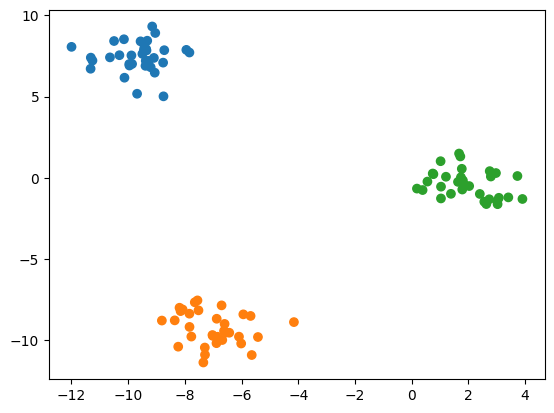

In [80]:
plot(X, y)

# z-threeml

In [81]:
def get_value(x):
  if is_int_value(x):
    return x.as_long()
  if is_rational_value(x):
    return x.numerator_as_long() / x.denominator_as_long()
  if is_algebraic_value(x):
    return x.approx()
  raise ValueError(f"I don't know what {x} is")

def argmax(logits, ix, max_val):
    # Based on http://www.hakank.org/z3/argmax.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append((ix == i) == (logits[i] == max_val))
    return terms

def maximum(logits, max_val):
    # Based on http://www.hakank.org/z3/max.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append(max_val >= logits[i])
    return terms

In [99]:
class z3Linear:
  def __init__(self, n_features, dtype=Real):
    self.w = np.array([dtype(f"w_{i}") for i in range(n_features)])
    self.b = np.array([dtype("b")])

  def forward(self, x):
    return x @ self.w + self.b

  def pred(self, x):
    logits = self.forward(x)
    return logits > 0

  def realize(self, model):
    self.w = np.array([get_value(model[w]) for w in self.w.ravel()]).reshape(*self.w.shape)
    self.b = np.array([get_value(model[b]) for b in self.b.ravel()]).reshape(*self.b.shape)
    return self

# This is the loss that should be paired with a 2 class classifier
def threshold_loss(logits, y):
  """Losses return lists or lists of constraints."""
  return [np.vectorize(lambda l, y: If(bool(y == 0), l < 0, l > 0))(logits, y)]

In [100]:
class z3MultiClassLinear(z3Linear):
    def __init__(self, n_features, n_output, dtype=Real):
        self.w = np.array(
            [[dtype(f"w_{i},{j}") for j in range(n_output)]
             for i in range(n_features)]
        )
        self.b = np.array([dtype(f"b_{i}") for i in range(n_output)])

    def pred(self, x):
        logits = self.forward(x)
        return np.argmax(logits, axis=-1)

    def loss(self, logits, y):
        terms = []
        for i, (l, y_) in enumerate(zip(logits, y)):
            ts = []
            ix = Int(f"argmax_{i}")
            max_val = Real(f"max_{i}")
            ts.extend(maximum(l, max_val))
            ts.extend(argmax(l, ix, max_val))
            ts.append(ix == y_)
            terms.append(ts)
        return terms

# This loss is paired with anything that has more than 2 classes
def multiclass_loss(logits, y):
    """Losses return lists of lists of constraints."""
    terms = []
    for i, (l, y_) in enumerate(zip(logits, y)):
        ts = []
        ix = Int(f"argmax_{i}")
        max_val = Real(f"max_{i}")
        ts.extend(maximum(l, max_val))
        ts.extend(argmax(l, ix, max_val))
        ts.append(ix == y_)
        terms.append(ts)
    return terms

In [101]:
def relu(x):
    # Based on https://gist.github.com/philzook58/5aab67b65b476bb55e6b9c403ccabed2
    return np.vectorize(lambda y: If(y >= 0, y, RealVal(0)))(x)

class z3MLP(z3MultiClassLinear):
    def __init__(self, n_features, n_hidden, n_output, dtype=Real):
        self.ws = []
        self.bs = []
        if not isinstance(n_hidden, list):
            n_hidden = [n_hidden]
        for i, (in_, out) in enumerate(zip([n_features, *n_hidden], [*n_hidden, n_output])):
            w = np.array([
                [dtype(f"w_{i},{j},{k}") for k in range(out)]
                for j in range(in_)
            ])
            self.ws.append(w)
            b = np.array([dtype(f"b_{i},{j}") for j in range(out)])
            self.bs.append(b)
        self.relu = relu

    def forward(self, x):
        for w, b in zip(self.ws[:-1], self.bs[:-1]):
            x = x @ w + b
            x = self.relu(x)
        return x @ self.ws[-1] + self.bs[-1]

    def realize(self, m):
        self.ws = [
            np.array([get_value(m[w]) for w in ws.ravel()]).reshape(*ws.shape)
            for ws in self.ws
        ]
        self.bs = [
            np.array([get_value(m[b]) for b in bs.ravel()]).reshape(*bs.shape)
            for bs in self.bs
        ]
        self.relu = lambda x: np.maximum(x, 0)
        return self

In [102]:
def train(x, y, model, loss):
    """The 'training loop'."""
    # Create a symbolic representation of the logits created by the model for every datapoint.
    logits = model.forward(x)
    # Create a constraint that the symbolic logits represent the right answer
    return loss(logits, y)

In [115]:
seed = 42

sat
Model Parameters:
 w: [ 0.12992778 -0.07824544]
 b: [0.29876946]


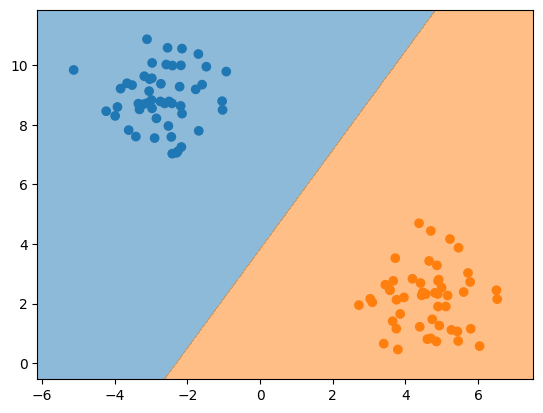

In [116]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)

ml = z3Linear(NUM_FEATURES)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [2 0]
 b: [1]


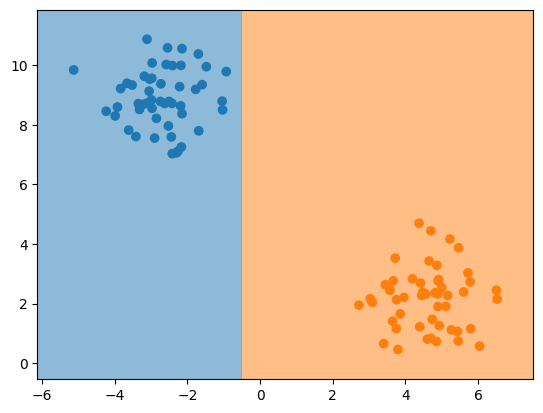

In [117]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)

ml = z3Linear(NUM_FEATURES, dtype=Int)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [[-0.62387299  0.31525252 -0.1829057 ]
 [ 0.24578263 -0.31134908 -0.03921091]]
 b: [-4.20721978 -1.48808078 -1.74238036]


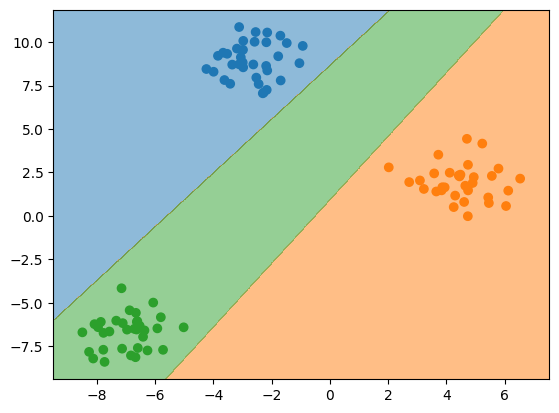

In [118]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [[-1 70 -1]
 [54  1 52]]
 b: [-2  3 -2]


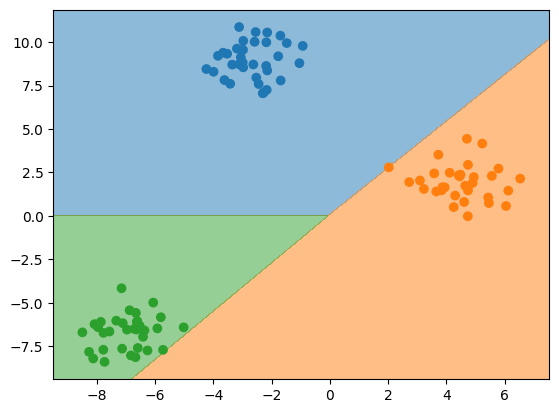

In [120]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES, dtype=Int)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

# Not Linearly Separable

## XOR

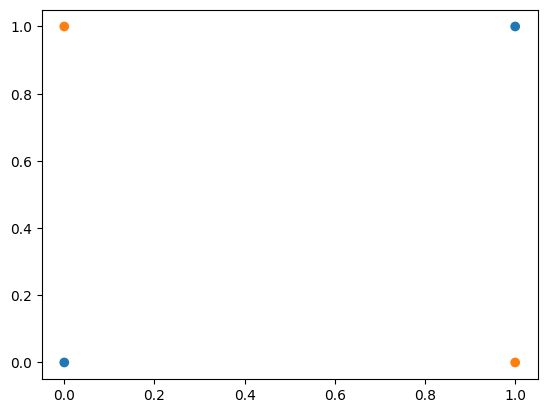

In [121]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]])
y = np.array([0, 1, 1, 0])

plot(X, y)

In [122]:
ml = z3MultiClassLinear(2, 2)
terms = setup_train(X, y, ml)

s = Solver()
s.add(*itertools.chain(*terms))
print(s.check(), "as expected")

unsat as expected


sat
Model Parameters:
 ws: [array([[4, 0, 2],
       [0, 4, 2]]), array([[-2,  1],
       [ 3,  4],
       [10,  2]])]
 bs: [array([-2, -2, -3]), array([1, 0])]


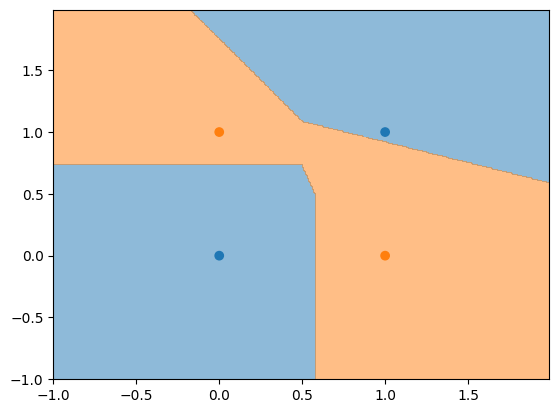

In [125]:
ml = z3MLP(2, 3, 2, dtype=Int)  # This takes forwver with a dtype of Real
terms = setup_train(X, y, ml)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  ml = ml.realize(s.model())

  print("Model Parameters:")
  print(f" ws: {ml.ws}")
  print(f" bs: {ml.bs}")
  plot_boundry(X, y, ml.pred)
  plot(X, y)

## More Realistic Non-separable

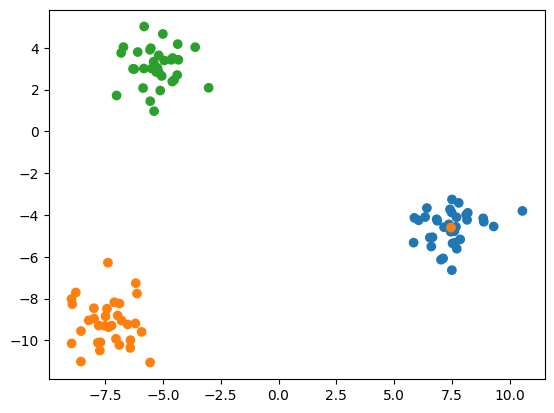

In [134]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=128)

# Create a datapoint in the wrong cluster
X_ns = np.concatenate([X, np.mean(X[y == 0], axis=0, keepdims=True)], axis=0)
y_ns = np.concatenate([y, [1]], axis=0)

plot(X_ns, y_ns)

In [185]:
ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = setup_train(X_ns, y_ns, ml)

s = Solver()
s.set(unsat_core=True)
for i, ts in enumerate(terms):
  for j, t in enumerate(ts):
    if j == (len(ts) - 1):
      s.assert_and_track(t, f"d{i}")
    else:
      s.add(t)
print(s.check(), "as expected")

unsat as expected


In [186]:
def plot_unsat(x, y, unsat):
    plt.scatter(*x.T, color=COLORS[y])
    plt.scatter(*x[unsat].T, color=COLORS[y[unsat]], edgecolor="k")

There are 4 constraints in the UNSAT-core: [d100, d0, d3, d32]


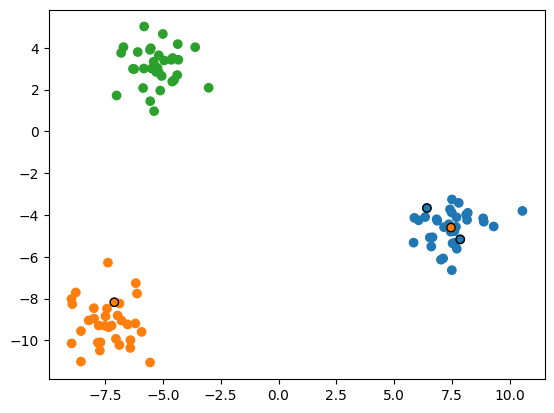

In [187]:
c = s.unsat_core()
print(f"There are {len(c)} constraints in the UNSAT-core: {c}")

unsat = [int(str(u)[1:]) for u in c]

plot_unsat(X_ns, y_ns, unsat)

In [188]:
def plot_max(x, y, y_pred):
    plt.scatter(*x.T, color=COLORS[y])
    plt.scatter(*x[y != y_pred].T, color=COLORS[y[y != y_pred]], edgecolor=COLORS[y_pred[y != y_pred]])

sat
Model Accuracy: 99.0099


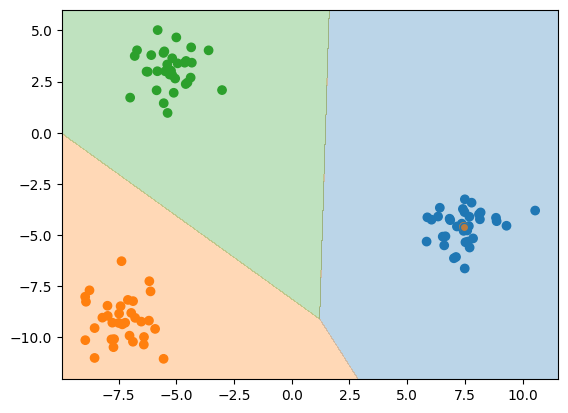

In [189]:
o = Optimize()  # A MaxSAT solver, it takes longer
for i, ts in enumerate(terms):
    for j, t in enumerate(ts):
        if j == (len(ts) - 1):
            o.add_soft(t)
        else:
            o.add(t)
status = o.check()
print(status)
if status == sat:
    ml = ml.realize(o.model())
    y_hat = ml.pred(X_ns)
    print(f"Model Accuracy: {sum(y_hat == y_ns)/len(y_ns)*100:.4f}")

    plot_max(X_ns, y_ns, y_hat)
    plot_boundry(X_ns, y_ns, ml.pred, alpha=0.3)

# Simple Scaling

In [175]:
times = []
num_examples = [2 ** i for i in range(16)]

for num_ex in num_examples:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=NUM_CLASSES)
        ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
        terms = train(X, y, ml, multiclass_loss)
        s = Solver()
        s.add(*itertools.chain(*terms))
        tic = time.time()
        status = s.check()
        toc = time.time()
    times.append(toc - tic)
    print(f"Solved for {num_ex} examples.")

Solved for 1 examples.
Solved for 2 examples.
Solved for 4 examples.
Solved for 8 examples.
Solved for 16 examples.
Solved for 32 examples.
Solved for 64 examples.
Solved for 128 examples.
Solved for 256 examples.
Solved for 512 examples.
Solved for 1024 examples.
Solved for 2048 examples.
Solved for 4096 examples.
Solved for 8192 examples.
Solved for 16384 examples.
Solved for 32768 examples.


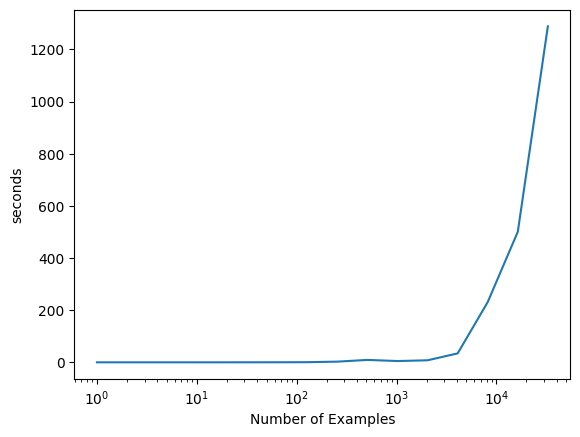

In [183]:
plt.plot(num_examples, times)
plt.xscale("log")
plt.ylabel("seconds")
plt.xlabel("Number of Examples");